# Лабораторная работа № 3. Задача классификации

In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install --upgrade scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 1.4 MB/s eta 0:00:08
   ---- ----------------------------------- 1.3/11.1 MB 2.8 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.1 MB 3.8 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.1 MB 4.0 MB/s eta 0:00:02
   ---------------- ----------------------- 4.5/11.1 MB 4.4 MB/s eta 0:00:02
   -------------------- ------------------- 5.8/11.1 MB 4.3 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.1 MB 4.4 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.1 MB 4.5 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.1 MB 4.4 MB/s eta 0:00:01
   -------------------------------- ------- 9.2/11.1 MB 4.2 MB/s eta 0:00:01
   ----------------------------------- ---- 10.0/11.1 MB 4.2 MB/s eta 0:00:01
   ---------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sklearn
print(sklearn.__version__)  

1.6.1


In [4]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%run lab3_custom_metrics.ipynb

In [6]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [7]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import matplotlib.pyplot as plt


from sklearn.metrics import (f1_score, accuracy_score, precision_score, recall_score,
                             confusion_matrix, roc_auc_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay)


from scipy.stats import loguniform
from scipy.stats import randint, uniform


import optuna
from optuna.samplers import TPESampler


import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


## Подготовка данных к задаче классификации

In [8]:
df = pd.read_csv(r'C:\Users\Zver\Desktop\ML\data\smoke_detector_task_filtered.csv', sep=',', encoding='utf-8')
df = df.drop(['Unnamed: 0'], axis=1)

### Выделение целевого признака и предикторов

In [9]:
label = 'Fire Alarm'
features = ['TVOC[ppb]', 'eCO2[ppm]', 'Temperature[C]', 'PM2.5', 'NC2.5', 'NC0.5', 'NC1.0', 'PM1.0', 'Humidity[%]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]']
X, y = df[features].values, df[label].values

- Это задача бинарной классификации, тк всего 2 исхода - 0 и 1 (не было пожара или был пожар)

In [10]:
fire_alarm_counts = df['Fire Alarm'].value_counts()
fire_alarm_counts

Fire Alarm
1    43257
0    16620
Name: count, dtype: int64

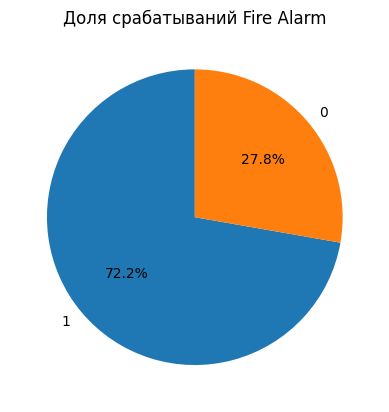

In [11]:
plt.figure()
plt.pie(fire_alarm_counts, labels=fire_alarm_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Доля срабатываний Fire Alarm')
plt.show()

- Есть дисбаланс классов

- В методе SMOTE выбирается одно из наблюдений минорного класса, для него идет поиск k ближайших соседей из того же минорного класса. На отрезках между «соседями» выбирается случайный объект, который искусственно расширяет выборку.

In [12]:
# Разделение данных на тренировочные и тестовые
X_train0, X_test0, y_train0, y_test1 = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Масштабирование
scaler = StandardScaler()
X_train0_scaled = scaler.fit_transform(X_train0)
X_test1 = scaler.transform(X_test0)

# Применение SMOTE к тренировочным данным
smote = SMOTE(random_state=42)
X_train1, y_train1 = smote.fit_resample(X_train0_scaled, y_train0)

### Разделение на выборки 

In [13]:
# Распределение в тестовой выборке и обучающей
print("Тестовая выборка:")
print(pd.Series(y_test1).value_counts())
print("Обучающая выборка:")
print(pd.Series(y_train1).value_counts())

Тестовая выборка:
1    8652
0    3324
Name: count, dtype: int64
Обучающая выборка:
1    34605
0    34605
Name: count, dtype: int64


# Алгоритмы классификации (для выборок через train_test_split)

## Логистическая регрессия

In [44]:
# Функция для оценки модели
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        'f1': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    
def plot_model_evaluation(model, X_test, y_test, model_name):
    # Получаем предсказания и вероятности
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_model(model, X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)

    # Создаем фигуру с двумя subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.set_xlabel('FP Rate')
    ax1.set_ylabel('TP Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    metrics_text = (
        f"Accuracy: {metrics['accuracy']:.4f}\n"
        f"Precision: {metrics['precision']:.4f}\n"
        f"Recall: {metrics['recall']:.4f}\n"
        f"F1: {metrics['f1']:.4f}\n"
        f"AUC: {roc_auc:.4f}"
    )
    ax1.text(0.6, 0.2, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=10)

    # Матрица ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix')

    plt.suptitle(f'Логистическая регрессия ({model_name})', fontsize=14)
    plt.tight_layout()
    plt.show()

    return metrics

GridSearchCV параметрыs: {'C': 10, 'max_iter': 20, 'penalty': 'l1', 'solver': 'liblinear'}


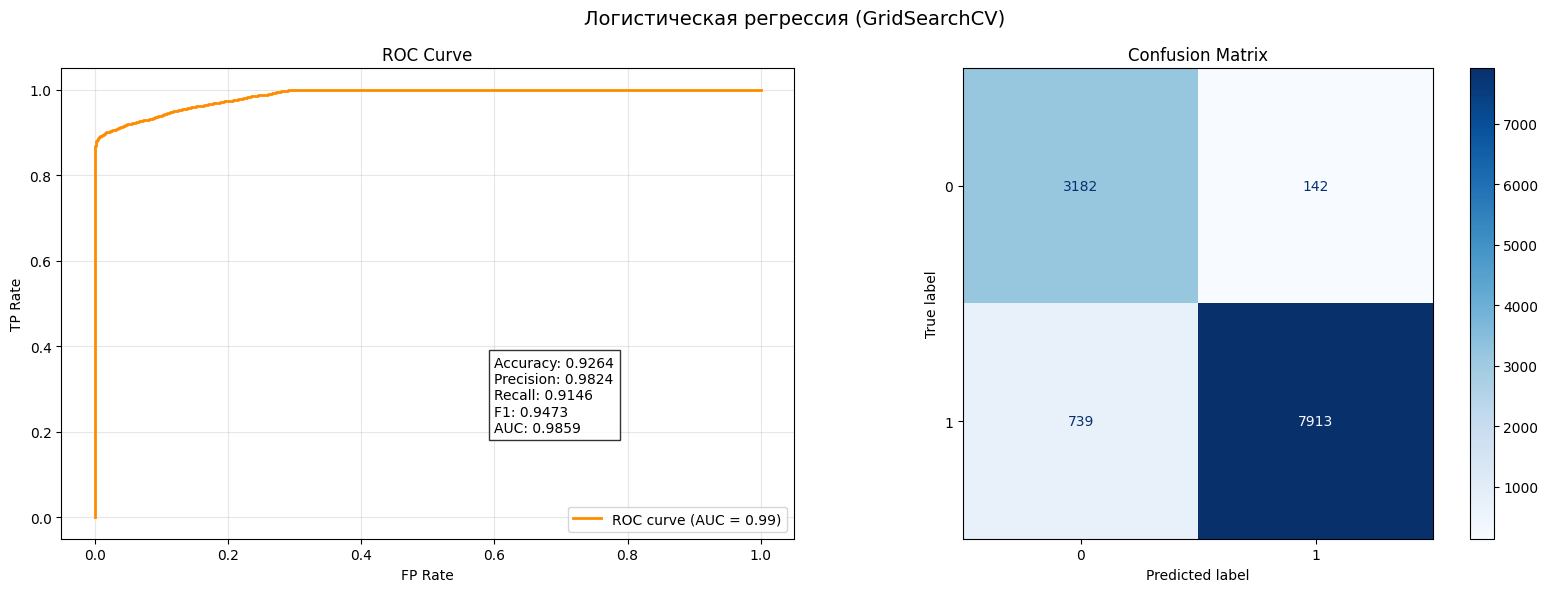

RandomizedSearchCV параметры: {'C': 78.52755494724258, 'max_iter': 20, 'penalty': 'l1', 'solver': 'liblinear'}


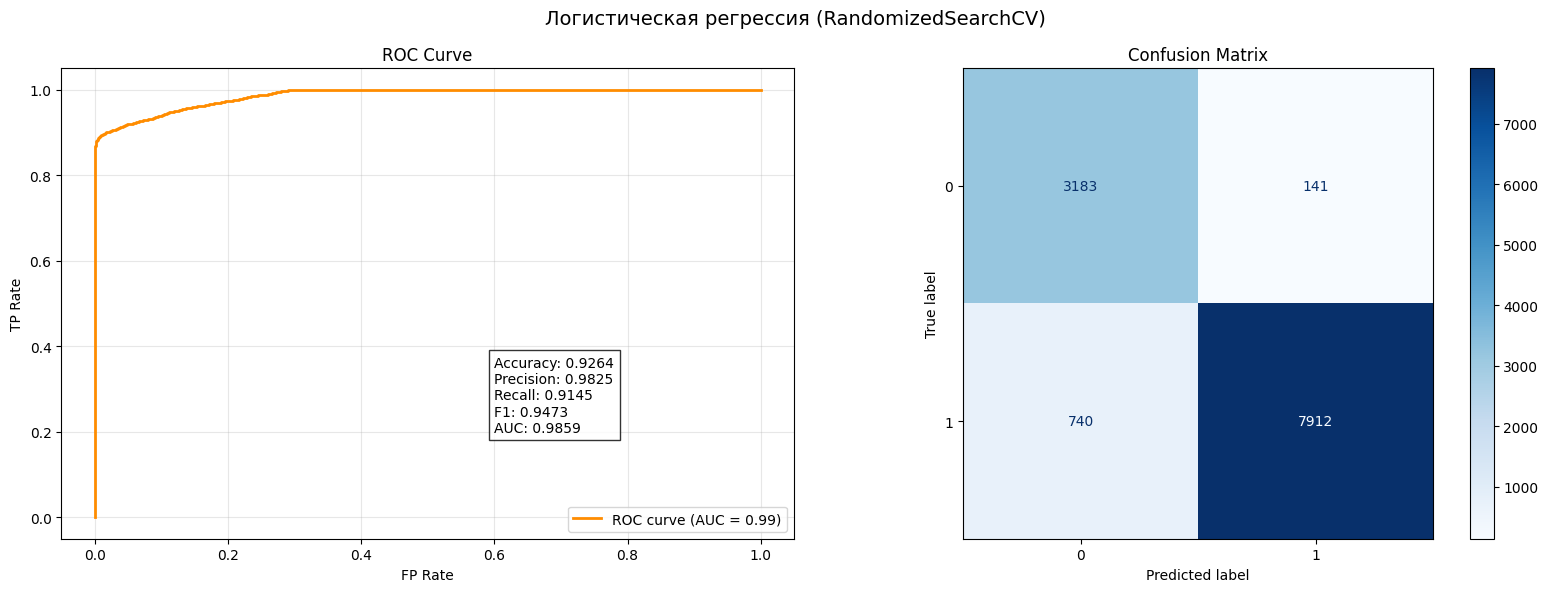

[I 2025-05-04 23:58:46,708] A new study created in memory with name: no-name-4068b00a-e368-481e-aa63-fbaedb853cd9
[I 2025-05-04 23:58:47,170] Trial 0 finished with value: 0.9329062817437555 and parameters: {'C': 0.31489116479568624}. Best is trial 0 with value: 0.9329062817437555.
[I 2025-05-04 23:58:47,816] Trial 1 finished with value: 0.9340987391295297 and parameters: {'C': 63.512210106407046}. Best is trial 1 with value: 0.9340987391295297.
[I 2025-05-04 23:58:48,375] Trial 2 finished with value: 0.9340929698100036 and parameters: {'C': 8.471801418819979}. Best is trial 1 with value: 0.9340987391295297.
[I 2025-05-04 23:58:48,881] Trial 3 finished with value: 0.9340578532367632 and parameters: {'C': 2.481040974867813}. Best is trial 1 with value: 0.9340987391295297.
[I 2025-05-04 23:58:49,308] Trial 4 finished with value: 0.927281249028873 and parameters: {'C': 0.04207988669606638}. Best is trial 1 with value: 0.9340987391295297.
[I 2025-05-04 23:58:49,717] Trial 5 finished with va

Optuna параметры: {'C': 6.79657809075816}


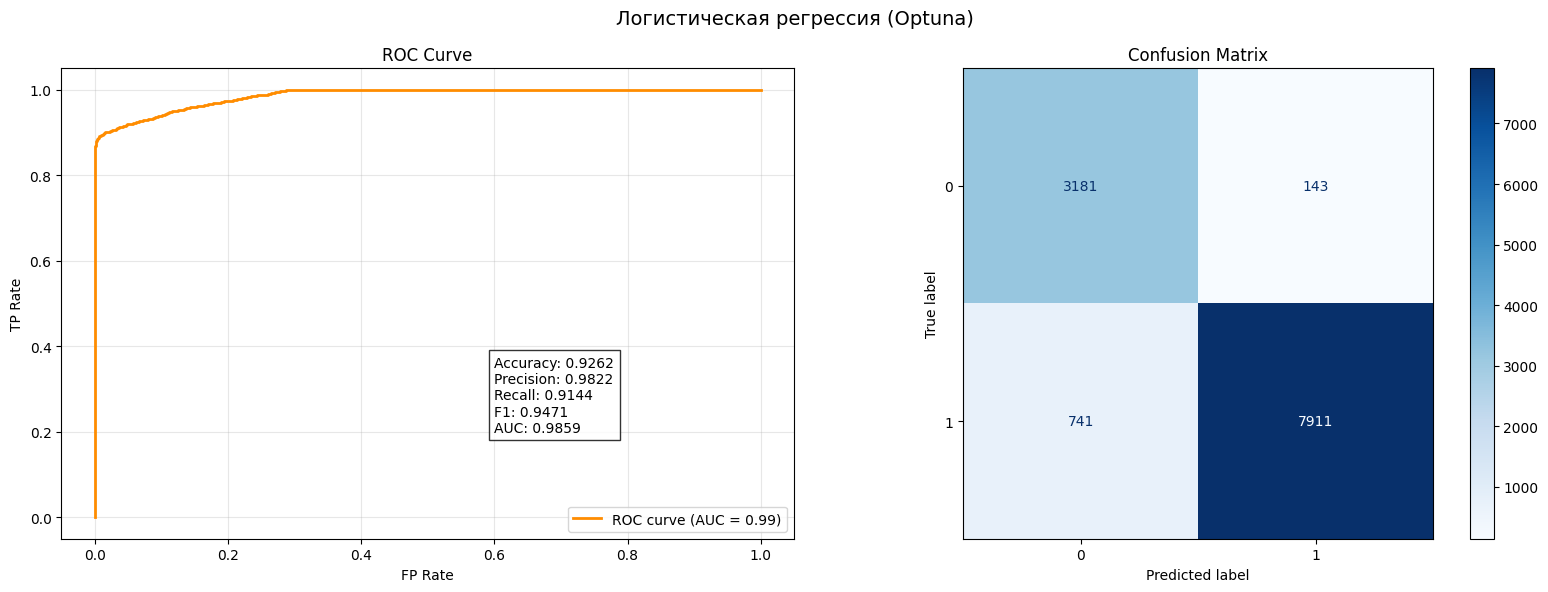

In [45]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [20]
}
grid_search1 = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search1.fit(X_train1, y_train1)
best_grid1 = grid_search1.best_estimator_
print("GridSearchCV параметрыs:", grid_search1.best_params_)
metrics_grid = plot_model_evaluation(best_grid1, X_test1, y_test1, "GridSearchCV")




param_dist = {
    'penalty': ['l1', 'l2'],
    'C': loguniform(1e-2, 1e2),
    'solver': ['liblinear'],
    'max_iter': [20]
}
random_search1 = RandomizedSearchCV(LogisticRegression(), param_dist, n_iter=20, cv=3, scoring='f1', random_state=42, n_jobs=-1)
random_search1.fit(X_train1, y_train1)
best_random1 = random_search1.best_estimator_
print("RandomizedSearchCV параметры:", random_search1.best_params_)
metrics_random = plot_model_evaluation(best_random1, X_test1, y_test1, "RandomizedSearchCV")




def objective(trial):
    params = {
        'penalty': 'l2',
        'C': trial.suggest_float('C', 1e-2, 1e2, log=True),
        'solver': 'liblinear',
        'max_iter': 30
    }
    model = LogisticRegression(**params)
    return np.mean(cross_val_score(model, X_train1, y_train1, cv=3, scoring='f1'))

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=30)

best_optuna1 = LogisticRegression(**study.best_params, random_state=42)
best_optuna1.fit(X_train1, y_train1)
print("Optuna параметры:", study.best_params)
metrics_optuna = plot_model_evaluation(best_optuna1, X_test1, y_test1, "Optuna")

In [46]:
# Список всех моделей
models = [
    ('LogisticRegression (GridSearchCV)', grid_search1),
    ('LogisticRegression (RandomizedSearchCV)', random_search1),
    ('LogisticRegression (Optuna)', best_optuna1)
    
]

for name, model in models:
    # Предсказания на тестовых данных
    y_pred = model.predict(X_test1)
    
    try:
        y_proba = model.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, y_proba)
    except (AttributeError, NotImplementedError):
        y_proba = None
        roc_auc = "Not available"
    
    # Accuracy на обучающих данных
    accuracy_train = accuracy_score(y_train1, model.predict(X_train1))
    
    # Accuracy на тестовых данных
    accuracy_test = accuracy_score(y_test1, y_pred)
    
    # Вывод результатов
    print("="*60)
    print(f"Модель: {name}")
    
    print("\nClassification Report:")
    print(classification_report(y_test1, y_pred, zero_division=0))
    
    print(f"\nAccuracy (train): {accuracy_train:.4f} ({accuracy_train:.1%})")
    print(f"Accuracy (test): {accuracy_test:.4f} ({accuracy_test:.1%})")
    
    # Матрица ошибок
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test1, y_pred))
    
    # ROC-AUC 
    print(f"\nROC-AUC: {roc_auc}")
    
    # Дополнительные метрики с zero_division
    precision = precision_score(y_test1, y_pred, zero_division=0)
    recall = recall_score(y_test1, y_pred)
    f1 = f1_score(y_test1, y_pred)
    
    print("="*60)

Модель: LogisticRegression (GridSearchCV)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3324
           1       0.98      0.91      0.95      8652

    accuracy                           0.93     11976
   macro avg       0.90      0.94      0.91     11976
weighted avg       0.93      0.93      0.93     11976


Accuracy (train): 0.9357 (93.6%)
Accuracy (test): 0.9264 (92.6%)

Confusion Matrix:
[[3182  142]
 [ 739 7913]]

ROC-AUC: 0.9858987967974684
Модель: LogisticRegression (RandomizedSearchCV)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3324
           1       0.98      0.91      0.95      8652

    accuracy                           0.93     11976
   macro avg       0.90      0.94      0.91     11976
weighted avg       0.93      0.93      0.93     11976


Accuracy (train): 0.9357 (93.6%)
Accuracy (test): 0.9264 (92.6%)



## KNN 

![Метрики](https://i2.wp.com/miro.medium.com/1*Lh6R4QArolCRdzF7jjSzDw.jpeg)

In [16]:
from platform import python_version

print(python_version())

3.10.0


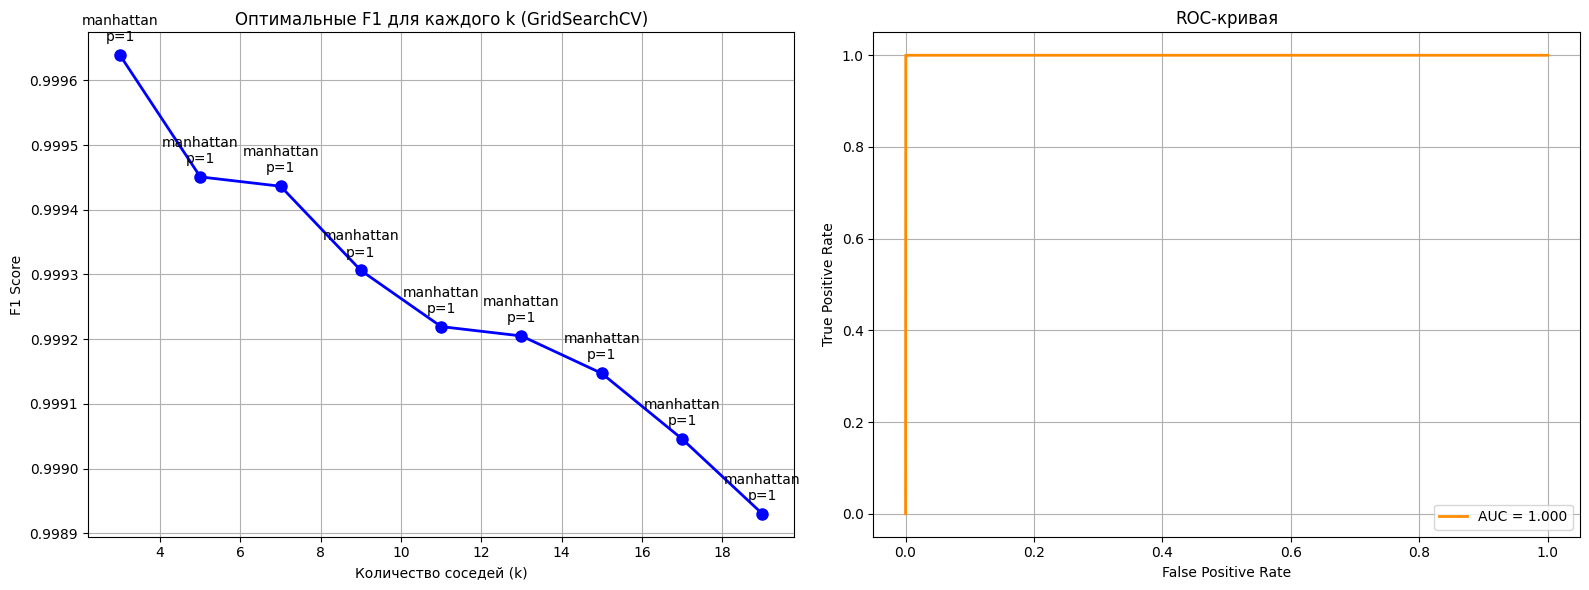

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Метрики на тесте: {'F1': 0.9998844197873324, 'Accuracy': 0.9998329993319973, 'Precision': 0.9998844197873324, 'Recall': 0.9998844197873324, 'ROC-AUC': 0.9998494745064266}

Матрица ошибок:
 [[3323    1]
 [   1 8651]]


['models/knn_model.pkl']

In [15]:
# Параметры для GridSearchCV
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19]
param_grid = {
    "n_neighbors": k_values,
    "weights": ["distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "p": [1, 2]
}

grid_search2 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)
grid_search2.fit(X_train1, y_train1)

# Получение метрик
y_pred = grid_search2.predict(X_test1)
y_proba = grid_search2.predict_proba(X_test1)[:, 1]

# Расчет метрик
metrics = {
    'F1': f1_score(y_test1, y_pred),
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Построение графиков
plt.figure(figsize=(16, 6))

# График 1: Оптимальные F1 из GridSearchCV
plt.subplot(1, 2, 1)
cv_results = pd.DataFrame(grid_search2.cv_results_)
best_scores = cv_results.groupby('param_n_neighbors')['mean_test_score'].max()
plt.plot(k_values, best_scores, 'b-o', linewidth=2, markersize=8, label='F1 (GridSearch)')

# Аннотации для лучших параметров
for k in k_values:
    best_params = cv_results[cv_results['param_n_neighbors'] == k].sort_values('mean_test_score', ascending=False).iloc[0]
    plt.annotate(f"{best_params['param_metric']}\np={best_params['param_p']}", 
                (k, best_scores[k]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.xlabel('Количество соседей (k)')
plt.ylabel('F1 Score')
plt.title('Оптимальные F1 для каждого k (GridSearchCV)')
plt.grid(True)

# График 2: ROC-кривая
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {metrics["ROC-AUC"]:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

print("Лучшие параметры:", grid_search2.best_params_)
print("\nМетрики на тесте:", metrics)
print("\nМатрица ошибок:\n", confusion_matrix(y_test1, y_pred))

import os
from joblib import dump

dump(grid_search2.best_estimator_, 'models/knn_model.pkl')

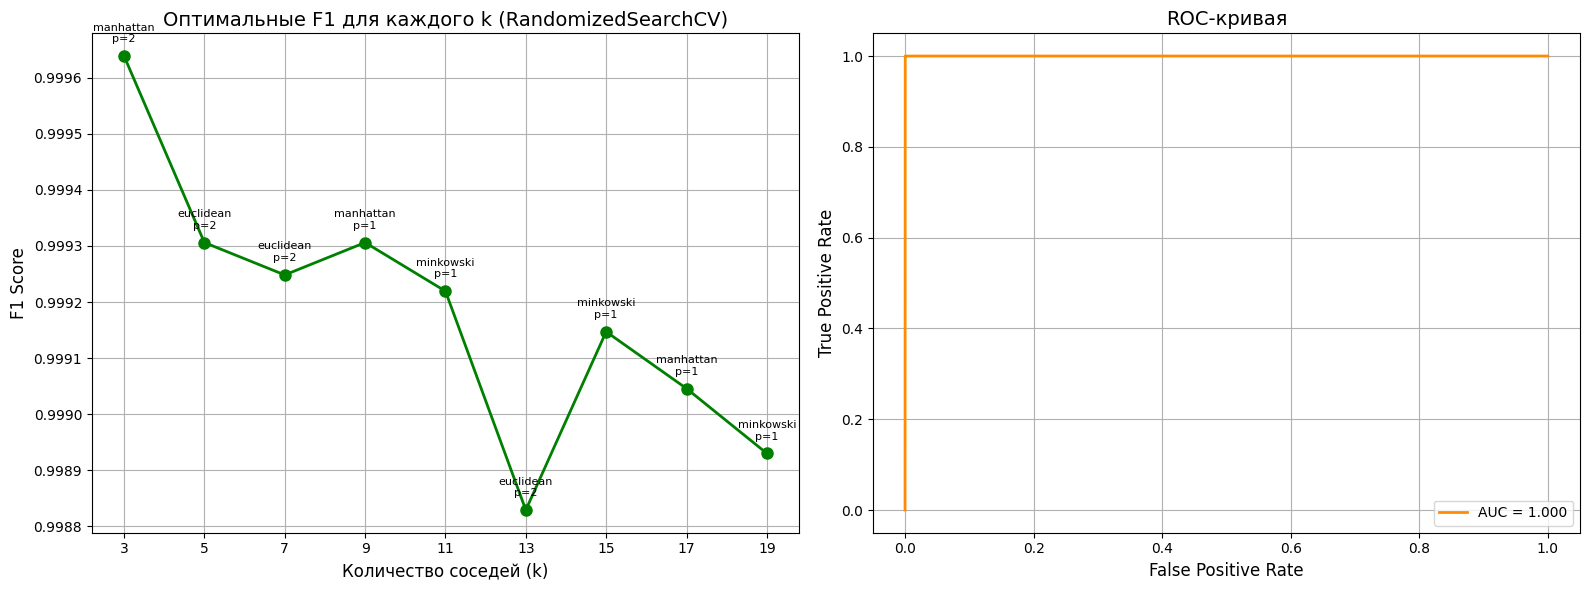

Лучшие параметры: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan'}

Метрики на тесте: {'F1': 0.9998844197873324, 'Accuracy': 0.9998329993319973, 'Precision': 0.9998844197873324, 'Recall': 0.9998844197873324, 'ROC-AUC': 0.9998494745064266}

Матрица ошибок:
 [[3323    1]
 [   1 8651]]


In [48]:
from sklearn.model_selection import RandomizedSearchCV

# Параметры для RandomizedSearchCV
param_dist = {
    "n_neighbors": k_values,
    "weights": ["distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "p": [1, 2]
}

random_search2 = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)
random_search2.fit(X_train1, y_train1)

# Получение метрик
y_pred = random_search2.predict(X_test1)
y_proba = random_search2.predict_proba(X_test1)[:, 1]

# Расчет метрик
metrics = {
    'F1': f1_score(y_test1, y_pred),
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Построение графиков
plt.figure(figsize=(16, 6))

# График 1: Оптимальные F1 из RandomizedSearchCV
plt.subplot(1, 2, 1)
cv_results = pd.DataFrame(random_search2.cv_results_)
cv_results['param_n_neighbors'] = cv_results['param_n_neighbors'].astype(int)

# Собираем все проверенные k значения
all_k_values = cv_results['param_n_neighbors'].unique()
best_scores = cv_results.groupby('param_n_neighbors')['mean_test_score'].max()

# Заполняем отсутствующие значения NaN
best_scores_full = pd.Series(index=k_values)
for k in k_values:
    best_scores_full[k] = best_scores.get(k, np.nan)

plt.plot(k_values, best_scores_full, 'g-o', linewidth=2, markersize=8, label='F1 (RandomizedSearch)')

# Аннотации для существующих значений
for k in all_k_values:
    best_params = cv_results[cv_results['param_n_neighbors'] == k].sort_values('mean_test_score', ascending=False).iloc[0]
    plt.annotate(f"{best_params['param_metric']}\np={best_params['param_p']}", 
                (k, best_scores[k]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=8)

plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Оптимальные F1 для каждого k (RandomizedSearchCV)', fontsize=14)
plt.grid(True)
plt.xticks(k_values)

# График 2: ROC-кривая
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {metrics["ROC-AUC"]:.3f}')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

print("Лучшие параметры:", random_search2.best_params_)
print("\nМетрики на тесте:", metrics)
print("\nМатрица ошибок:\n", confusion_matrix(y_test1, y_pred))

In [49]:
pip install scikit-learn-intelex
from sklearnex import patch_sklearn 
patch_sklearn()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3306315771.py, line 1)

[I 2025-05-04 22:27:25,666] A new study created in memory with name: no-name-9592b2e3-59f5-41b0-9d09-3708b682cf22
[I 2025-05-04 22:27:26,748] Trial 0 finished with value: 0.9997543563482082 and parameters: {'n_neighbors': 5, 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 0.9997543563482082.
[I 2025-05-04 22:27:26,891] Trial 1 finished with value: 0.9991039149826788 and parameters: {'n_neighbors': 15, 'metric': 'minkowski', 'p': 2}. Best is trial 0 with value: 0.9997543563482082.
[I 2025-05-04 22:27:28,442] Trial 2 finished with value: 0.9995953539961162 and parameters: {'n_neighbors': 15, 'metric': 'manhattan', 'p': 2}. Best is trial 0 with value: 0.9997543563482082.
[I 2025-05-04 22:27:30,100] Trial 3 finished with value: 0.9995230455659367 and parameters: {'n_neighbors': 19, 'metric': 'manhattan', 'p': 2}. Best is trial 0 with value: 0.9997543563482082.
[I 2025-05-04 22:27:30,244] Trial 4 finished with value: 0.9991039149826788 and parameters: {'n_neighbors': 15, 'metric

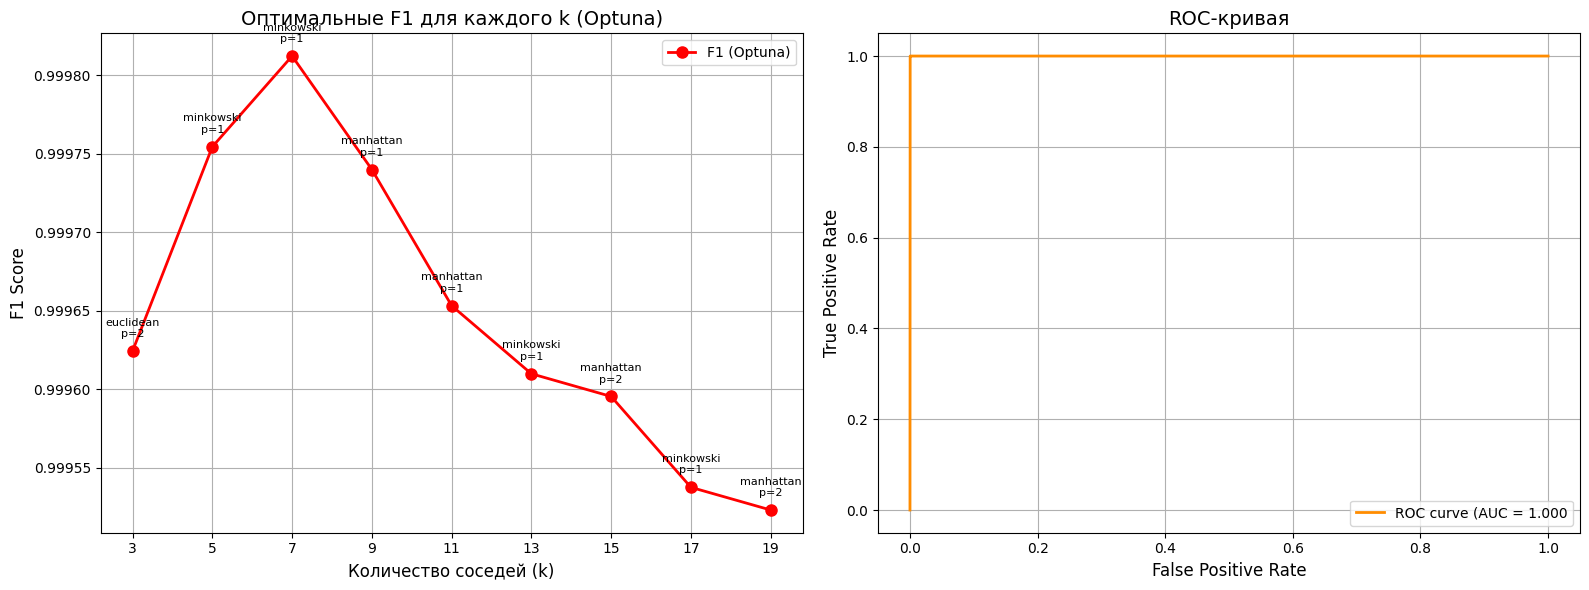

Лучшие параметры: {'n_neighbors': 7, 'metric': 'minkowski', 'p': 1}

Метрики на тесте: {'F1': 0.9998266196613304, 'Accuracy': 0.999749498997996, 'Precision': 0.9998844064270026, 'Recall': 0.9997688395746648, 'ROC-AUC': 0.9998493701921553}

Матрица ошибок:
 [[3323    1]
 [   2 8650]]


In [19]:
import optuna
from optuna.samplers import TPESampler
import numpy as np

# Функция для оптимизации
def objective(trial):
    params = {
        "n_neighbors": trial.suggest_categorical("n_neighbors", k_values),
        "weights": "distance",
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        "p": trial.suggest_categorical("p", [1, 2])
    }
    model = KNeighborsClassifier(**params)
    return np.mean(cross_val_score(model, X_train1, y_train1, cv=3, scoring="f1"))

# Создаем study и проводим оптимизацию
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=30)

# Подготовка данных для графика
trials_df = study.trials_dataframe()
best_scores = trials_df.groupby('params_n_neighbors')['value'].max()

# Заполняем все k_values (могут отсутствовать некоторые значения)
complete_scores = pd.Series(index=k_values, dtype=float)
for k in k_values:
    complete_scores[k] = best_scores.get(int(k), np.nan)

# Обучаем лучшую модель
best_model2 = KNeighborsClassifier(**study.best_params)
best_model2.fit(X_train1, y_train1)

# Получаем предсказания
y_pred = best_model2.predict(X_test1)
y_proba = best_model2.predict_proba(X_test1)[:, 1]

# Рассчитываем метрики
metrics = {
    'F1': f1_score(y_test1, y_pred),
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Создаем графики
plt.figure(figsize=(16, 6))

# График 1: Зависимость F1 от количества соседей (Optuna)
plt.subplot(1, 2, 1)
plt.plot(complete_scores.index, complete_scores.values, 'r-o', 
         linewidth=2, markersize=8, label='F1 (Optuna)')

# Добавляем аннотации для лучших параметров
for k in trials_df['params_n_neighbors'].unique():
    best_trial = trials_df[trials_df['params_n_neighbors'] == k].sort_values('value', ascending=False).iloc[0]
    plt.annotate(f"{best_trial['params_metric']}\np={best_trial['params_p']}",
                (k, best_trial['value']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=8)

plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Оптимальные F1 для каждого k (Optuna)', fontsize=14)
plt.xticks(k_values)
plt.grid(True)
plt.legend()

# График 2: ROC-кривая
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {metrics["ROC-AUC"]:.3f}')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

# Выводим результаты
print("Лучшие параметры:", study.best_params)
print("\nМетрики на тесте:", metrics)
print("\nМатрица ошибок:\n", confusion_matrix(y_test1, y_pred))

In [20]:
# Список всех моделей
models = [
    ('KNN (GridSearchCV)', grid_search2),
    ('KNN (RandomizedSearchCV)', random_search2),
    ('KNN (Optuna)', best_model2)
    
]

for name, model in models:
    # Предсказания на тестовых данных
    y_pred = model.predict(X_test1)
    
    try:
        y_proba = model.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, y_proba)
    except (AttributeError, NotImplementedError):
        y_proba = None
        roc_auc = "Not available"
    
    # Accuracy на обучающих данных
    accuracy_train = accuracy_score(y_train1, model.predict(X_train1))
    
    # Accuracy на тестовых данных
    accuracy_test = accuracy_score(y_test1, y_pred)
    
    # Вывод результатов
    print("="*60)
    print(f"Модель: {name}")
    
    print("\nClassification Report:")
    print(classification_report(y_test1, y_pred, zero_division=0))
    
    print(f"\nAccuracy (train): {accuracy_train:.4f} ({accuracy_train:.1%})")
    print(f"Accuracy (test): {accuracy_test:.4f} ({accuracy_test:.1%})")
    
    # Матрица ошибок
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test1, y_pred))
    
    # ROC-AUC 
    print(f"\nROC-AUC: {roc_auc}")
    
    # Дополнительные метрики с zero_division
    precision = precision_score(y_test1, y_pred, zero_division=0)
    recall = recall_score(y_test1, y_pred)
    f1 = f1_score(y_test1, y_pred)
    
    print("="*60)

Модель: KNN (GridSearchCV)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3324
           1       1.00      1.00      1.00      8652

    accuracy                           1.00     11976
   macro avg       1.00      1.00      1.00     11976
weighted avg       1.00      1.00      1.00     11976


Accuracy (train): 1.0000 (100.0%)
Accuracy (test): 0.9998 (100.0%)

Confusion Matrix:
[[3322    2]
 [   0 8652]]

ROC-AUC: 0.999849561434986
Модель: KNN (RandomizedSearchCV)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3324
           1       1.00      1.00      1.00      8652

    accuracy                           1.00     11976
   macro avg       1.00      1.00      1.00     11976
weighted avg       1.00      1.00      1.00     11976


Accuracy (train): 1.0000 (100.0%)
Accuracy (test): 0.9998 (100.0%)

Confusion Matrix:
[[3322   

## Naive Bayes

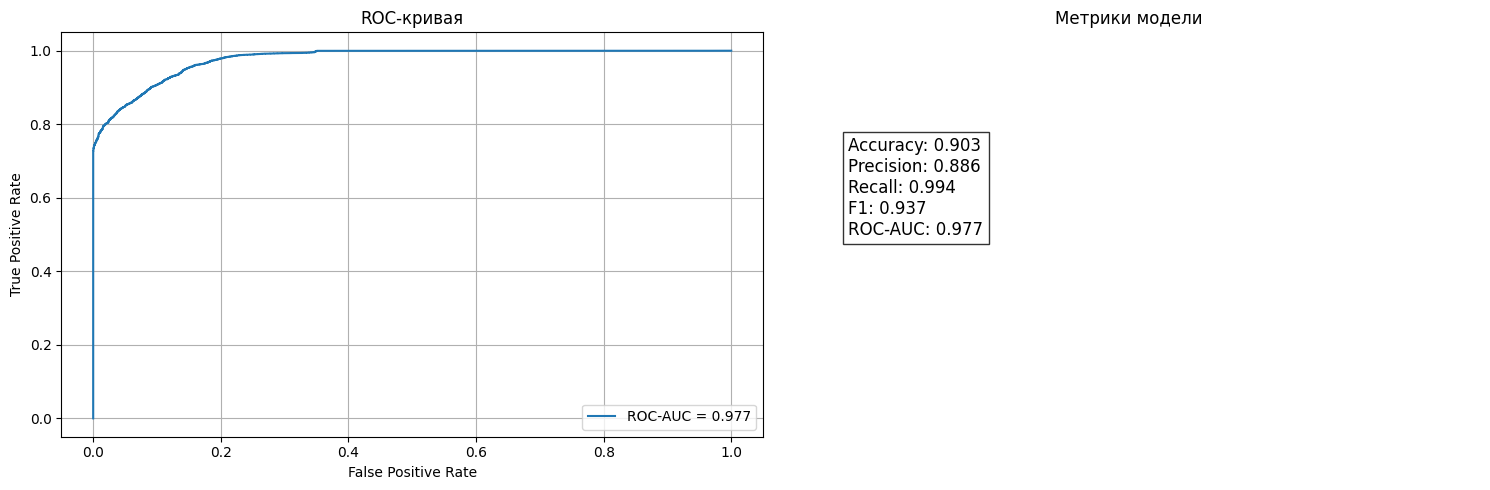

Матрица ошибок:
[[2218 1106]
 [  50 8602]]


In [21]:
# Обучение модели
gnb1 = GaussianNB()
gnb1.fit(X_train1, y_train1)

# Предсказания
y_pred = gnb1.predict(X_test1)
y_proba = gnb1.predict_proba(X_test1)[:, 1]

# Расчет метрик
metrics = {
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'F1': f1_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Матрица ошибок
cm = confusion_matrix(y_test1, y_pred)

# Визуализация
plt.figure(figsize=(15, 5))

# График 1: ROC-кривая
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {metrics["ROC-AUC"]:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid()

# График 2: Вывод метрик
plt.subplot(1, 2, 2)
plt.axis('off')
metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
plt.text(0.1, 0.5, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.title('Метрики модели')

plt.tight_layout()
plt.show()

print("Матрица ошибок:")
print(cm)


In [22]:
models = [
    ('GaussianNB', gnb1)
    
]

for name, model in models:
    # Предсказания на тестовых данных
    y_pred = model.predict(X_test1)
    
    try:
        y_proba = model.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, y_proba)
    except (AttributeError, NotImplementedError):
        y_proba = None
        roc_auc = "Not available"
    
    # Accuracy на обучающих данных
    accuracy_train = accuracy_score(y_train1, model.predict(X_train1))
    
    # Accuracy на тестовых данных
    accuracy_test = accuracy_score(y_test1, y_pred)
    
    # Вывод результатов
    print("="*60)
    print(f"Модель: {name}")
    
    print("\nClassification Report:")
    print(classification_report(y_test1, y_pred, zero_division=0))
    
    print(f"\nAccuracy (train): {accuracy_train:.4f} ({accuracy_train:.1%})")
    print(f"Accuracy (test): {accuracy_test:.4f} ({accuracy_test:.1%})")
    
    # Матрица ошибок
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test1, y_pred))
    
    # ROC-AUC 
    print(f"\nROC-AUC: {roc_auc}")
    
    # Дополнительные метрики с zero_division
    precision = precision_score(y_test1, y_pred, zero_division=0)
    recall = recall_score(y_test1, y_pred)
    f1 = f1_score(y_test1, y_pred)
    
    print("="*60)

Модель: GaussianNB

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.79      3324
           1       0.89      0.99      0.94      8652

    accuracy                           0.90     11976
   macro avg       0.93      0.83      0.87     11976
weighted avg       0.91      0.90      0.90     11976


Accuracy (train): 0.8274 (82.7%)
Accuracy (test): 0.9035 (90.3%)

Confusion Matrix:
[[2218 1106]
 [  50 8602]]

ROC-AUC: 0.97745561705925


## SVM

C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


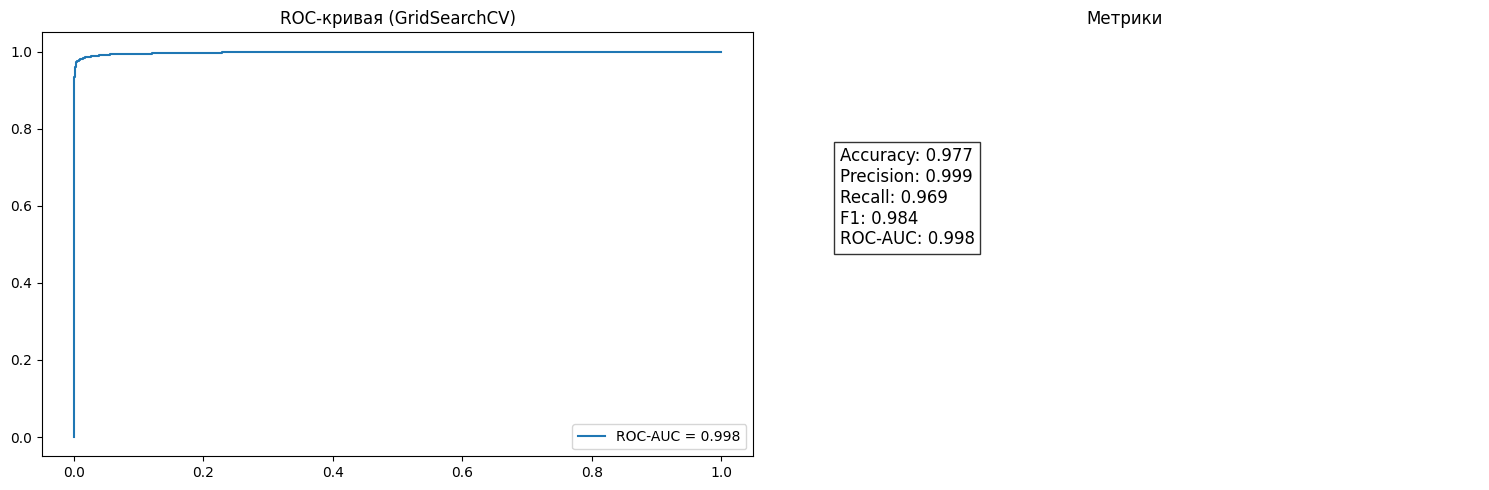

Матрица ошибок:
[[3315    9]
 [ 265 8387]]
Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [23]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'C': [0.1, 1],
    'gamma': ['scale']
}

grid_search3 = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
)
grid_search3.fit(X_train1, y_train1)

y_pred = grid_search3.predict(X_test1)
y_proba = grid_search3.predict_proba(X_test1)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'F1': f1_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {metrics["ROC-AUC"]:.3f}')
plt.title('ROC-кривая (GridSearchCV)')
plt.legend()

plt.subplot(1, 2, 2)
plt.axis('off')
metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
plt.text(0.1, 0.5, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.title('Метрики')

plt.tight_layout()
plt.show()

print("Матрица ошибок:")
print(confusion_matrix(y_test1, y_pred))
print("Лучшие параметры:", grid_search3.best_params_)


C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


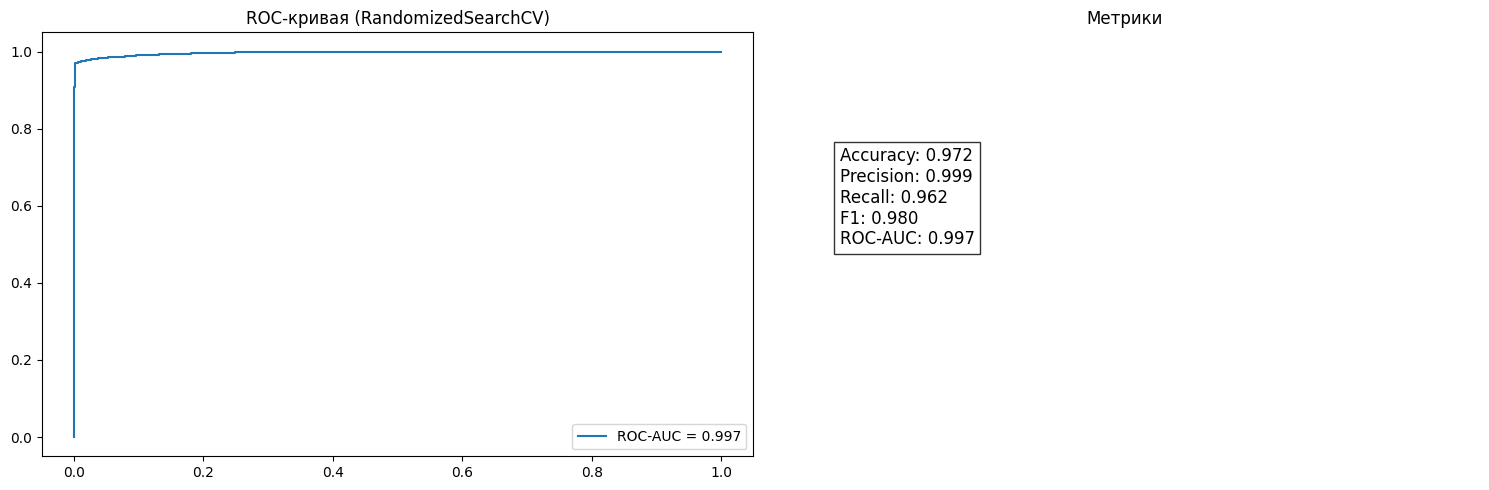

Матрица ошибок:
[[3319    5]
 [ 328 8324]]
Лучшие параметры: {'C': np.float64(1.5751320499779735), 'gamma': 'scale', 'kernel': 'poly'}


In [24]:
param_dist = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': loguniform(1e-1, 1e1),
    'gamma': ['scale']
}

random_search3 = RandomizedSearchCV(
    SVC(probability=True),
    param_dist,
    n_iter=3,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search3.fit(X_train1, y_train1)

# Метрики
y_pred = random_search3.predict(X_test1)
y_proba = random_search3.predict_proba(X_test1)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'F1': f1_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {metrics["ROC-AUC"]:.3f}')
plt.title('ROC-кривая (RandomizedSearchCV)')
plt.legend()

plt.subplot(1, 2, 2)
plt.axis('off')
metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
plt.text(0.1, 0.5, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.title('Метрики')

plt.tight_layout()
plt.show()

print("Матрица ошибок:")
print(confusion_matrix(y_test1, y_pred))
print("Лучшие параметры:", random_search3.best_params_)

[I 2025-04-27 17:15:44,002] A new study created in memory with name: no-name-1adec33c-ae40-4331-816d-e5f95d2d6101
[I 2025-04-27 17:15:56,023] Trial 0 finished with value: 0.9781299624038834 and parameters: {'kernel': 'rbf', 'C': 0.20513382630874505}. Best is trial 0 with value: 0.9781299624038834.
[I 2025-04-27 17:16:04,704] Trial 1 finished with value: 0.9813257495733149 and parameters: {'kernel': 'poly', 'C': 2.607024758370768}. Best is trial 1 with value: 0.9813257495733149.
[I 2025-04-27 17:16:16,996] Trial 2 finished with value: 0.9787170096067898 and parameters: {'kernel': 'rbf', 'C': 0.23102018878452935}. Best is trial 1 with value: 0.9813257495733149.
[I 2025-04-27 17:16:26,315] Trial 3 finished with value: 0.9705871111642992 and parameters: {'kernel': 'poly', 'C': 0.38234752246751863}. Best is trial 1 with value: 0.9813257495733149.
[I 2025-04-27 17:16:51,060] Trial 4 finished with value: 0.9473873253377031 and parameters: {'kernel': 'linear', 'C': 0.8168455894760165}. Best is

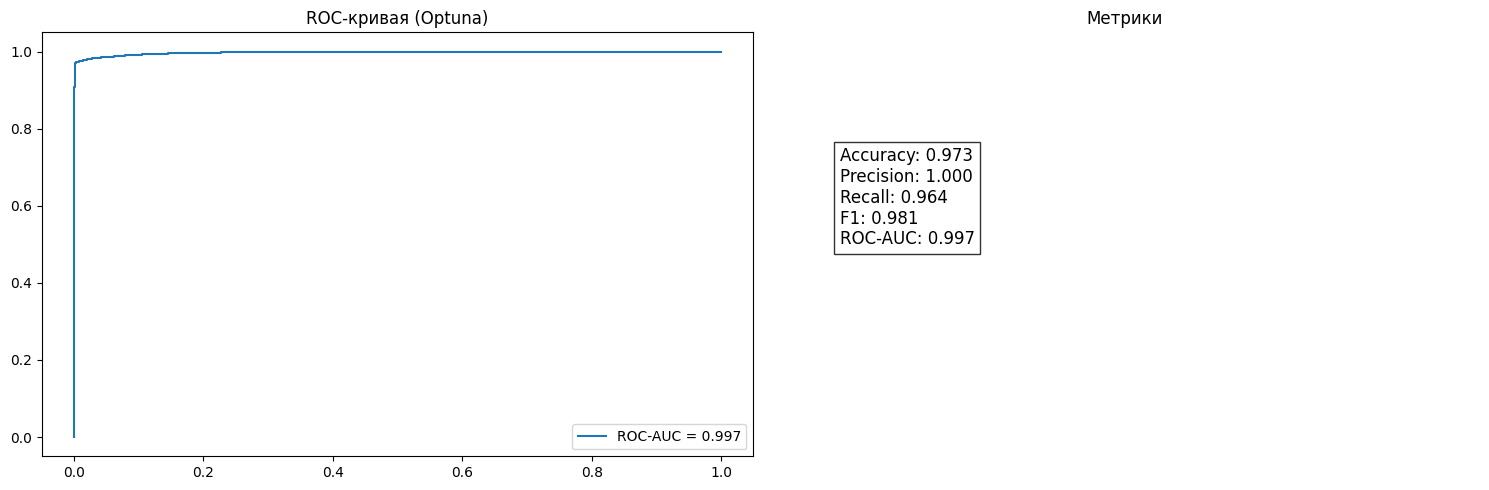

Матрица ошибок:
[[3320    4]
 [ 314 8338]]
Лучшие параметры: {'kernel': 'poly', 'C': 2.607024758370768}


In [25]:
kernels= ['linear', 'rbf', 'poly', 'sigmoid']
def objective(trial):
    params = {
        'kernel': trial.suggest_categorical('kernel', kernels),
        'C': trial.suggest_float('C', 1e-1, 1e1, log=True),
        'gamma': 'scale'
    }
    model = SVC(**params, probability=True)
    return np.mean(cross_val_score(model, X_train1, y_train1, cv=3, scoring='f1', n_jobs=-1))

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=10)

best_model3 = SVC(**study.best_params, probability=True)
best_model3.fit(X_train1, y_train1)

# Метрики
y_pred = best_model3.predict(X_test1)
y_proba = best_model3.predict_proba(X_test1)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test1, y_pred),
    'Precision': precision_score(y_test1, y_pred),
    'Recall': recall_score(y_test1, y_pred),
    'F1': f1_score(y_test1, y_pred),
    'ROC-AUC': roc_auc_score(y_test1, y_proba)
}

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test1, y_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {metrics["ROC-AUC"]:.3f}')
plt.title('ROC-кривая (Optuna)')
plt.legend()

plt.subplot(1, 2, 2)
plt.axis('off')
metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
plt.text(0.1, 0.5, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.title('Метрики')

plt.tight_layout()
plt.show()

print("Матрица ошибок:")
print(confusion_matrix(y_test1, y_pred))
print("Лучшие параметры:", study.best_params)

In [26]:
models = [
    ('SVM (GridSearchCV)', grid_search3),
    ('SVN (RandomizedSearchCV)', random_search3),
    ('SVM (Optuna)', best_model3)
    
]

for name, model in models:
    # Предсказания на тестовых данных
    y_pred = model.predict(X_test1)
    
    try:
        y_proba = model.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, y_proba)
    except (AttributeError, NotImplementedError):
        y_proba = None
        roc_auc = "Not available"
    
    # Accuracy на обучающих данных
    accuracy_train = accuracy_score(y_train1, model.predict(X_train1))
    
    # Accuracy на тестовых данных
    accuracy_test = accuracy_score(y_test1, y_pred)
    
    # Вывод результатов
    print("="*60)
    print(f"Модель: {name}")
    
    print("\nClassification Report:")
    print(classification_report(y_test1, y_pred, zero_division=0))
    
    print(f"\nAccuracy (train): {accuracy_train:.4f} ({accuracy_train:.1%})")
    print(f"Accuracy (test): {accuracy_test:.4f} ({accuracy_test:.1%})")
    
    # Матрица ошибок
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test1, y_pred))
    
    # ROC-AUC 
    print(f"\nROC-AUC: {roc_auc}")
    
    # Дополнительные метрики с zero_division
    precision = precision_score(y_test1, y_pred, zero_division=0)
    recall = recall_score(y_test1, y_pred)
    f1 = f1_score(y_test1, y_pred)
    
    print("="*60)

Модель: SVM (GridSearchCV)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3324
           1       1.00      0.97      0.98      8652

    accuracy                           0.98     11976
   macro avg       0.96      0.98      0.97     11976
weighted avg       0.98      0.98      0.98     11976


Accuracy (train): 0.9849 (98.5%)
Accuracy (test): 0.9771 (97.7%)

Confusion Matrix:
[[3315    9]
 [ 265 8387]]

ROC-AUC: 0.9981555498252249
Модель: SVN (RandomizedSearchCV)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3324
           1       1.00      0.96      0.98      8652

    accuracy                           0.97     11976
   macro avg       0.95      0.98      0.97     11976
weighted avg       0.97      0.97      0.97     11976


Accuracy (train): 0.9815 (98.1%)
Accuracy (test): 0.9722 (97.2%)

Confusion Matrix:
[[3319    5]

# Алгоритмы классификации (для выборок через кросс-валидацию)

#### В чем различие методов?
- k-fold: данные делятся на k фолдов. Модель обучается k раз: каждый раз на k-1 фолдах и тестируется на 1 фолде. И это более надежная оценка, так как модель проверяется на всех частях данных.
- train_test_split: данные делятся один раз на тренировочную и тестовую части (80/20). Менее стабильная оценка, тк зависит от случайного разбиения.

In [27]:
import warnings

warnings.filterwarnings("ignore", 
                        category=RuntimeWarning, 
                        message="random_state does not influence oneDAL SVM results")


from imblearn.pipeline import Pipeline as imbPipeline

In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
def plot_model_metrics(y_test, y_pred, y_proba, model_name):
    """Визуализация метрик для одной модели"""
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    
    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, 
              label=f'ROC AUC = {roc_auc:.2f}')
    ax[0].plot([0, 1], [0, 1], 'k--', lw=2)
    ax[0].set_title(f'ROC-кривая ({model_name})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend()
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[1], cmap='Blues')
    ax[1].set_title(f'Матрица ошибок ({model_name})')
    
    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose().round(2)
    ax[2].axis('off')
    table = ax[2].table(cellText=metrics_df.values,
                        colLabels=metrics_df.columns,
                        rowLabels=metrics_df.index,
                        loc='center',
                        cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax[2].set_title(f'Classification Report ({model_name})')
    
    plt.tight_layout()
    plt.show()

def evaluate_with_kfold(model, X, y, model_name, n_splits=5):
    # Оценка модели с K-Fold разделением
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Создание пайплайна с балансировкой и масштабированием
        pipeline = imbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])
        
        # Обучение и предсказания
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Расчет метрик
        metrics.append({
            'Fold': fold,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba)
        })
        
        # Визуализация для последнего фолда
        if fold == n_splits:
            plot_model_metrics(y_test, y_pred, y_proba, f"{model_name} (Fold {fold})")
    
    # Вывод средних метрик
    avg_metrics = pd.DataFrame(metrics).mean().to_dict()
    print(f"\n{'='*60}\nСредние метрики для {model_name}:\n{'='*60}")
    for k, v in avg_metrics.items():
        if k != 'Fold':
            print(f"{k}: {v:.4f}")
    
    

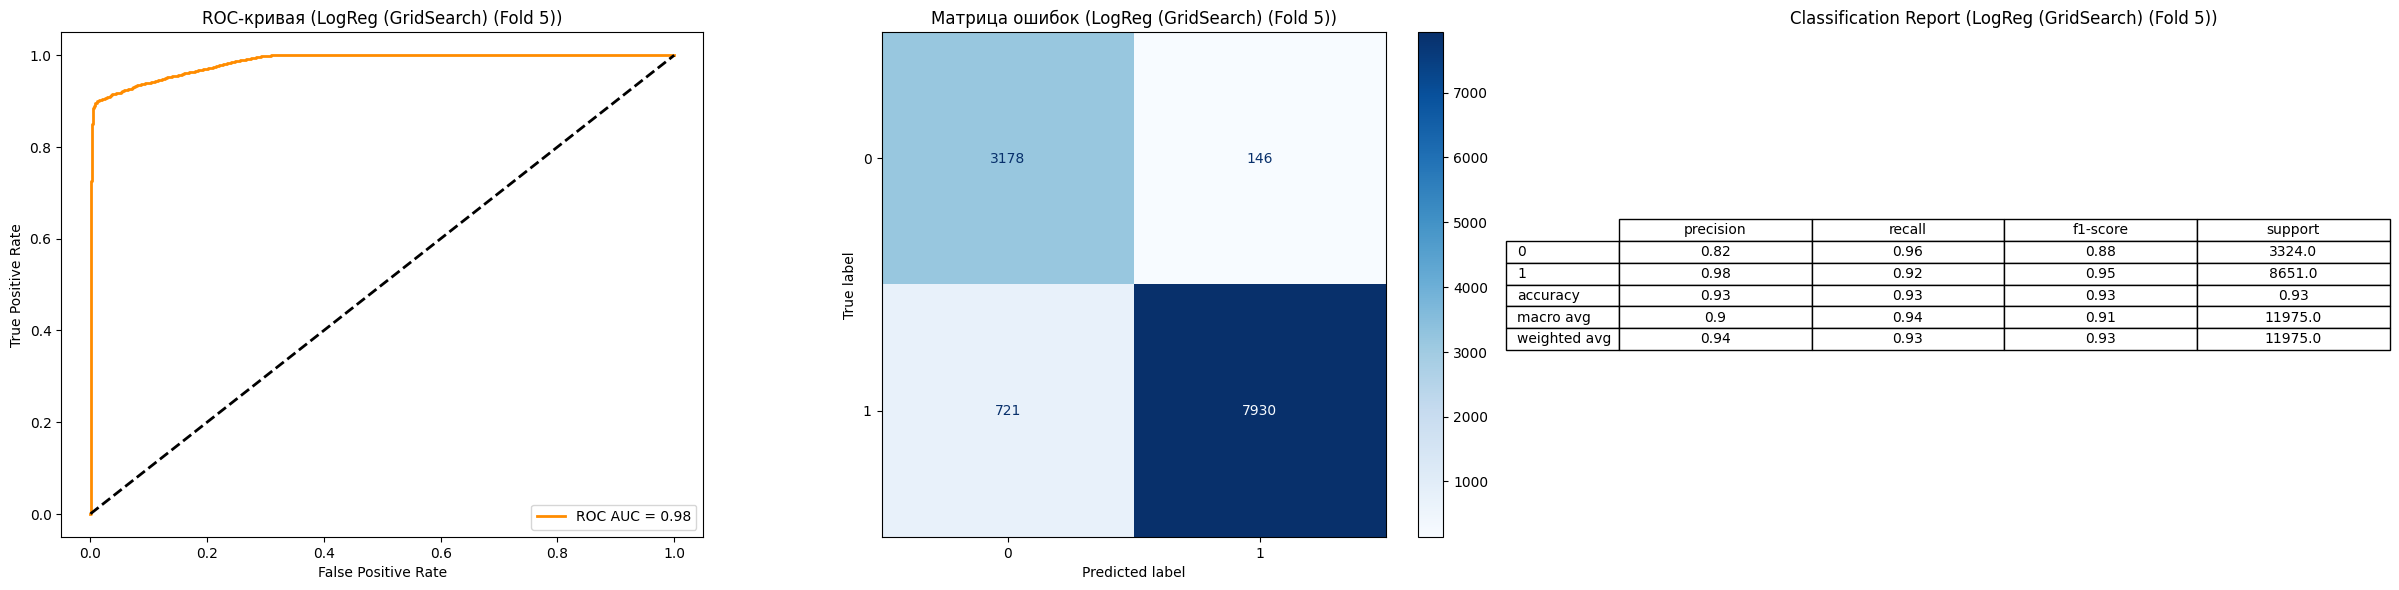


Средние метрики для LogReg (GridSearch):
Accuracy: 0.9264
Precision: 0.9816
Recall: 0.9152
F1: 0.9473
ROC AUC: 0.9847


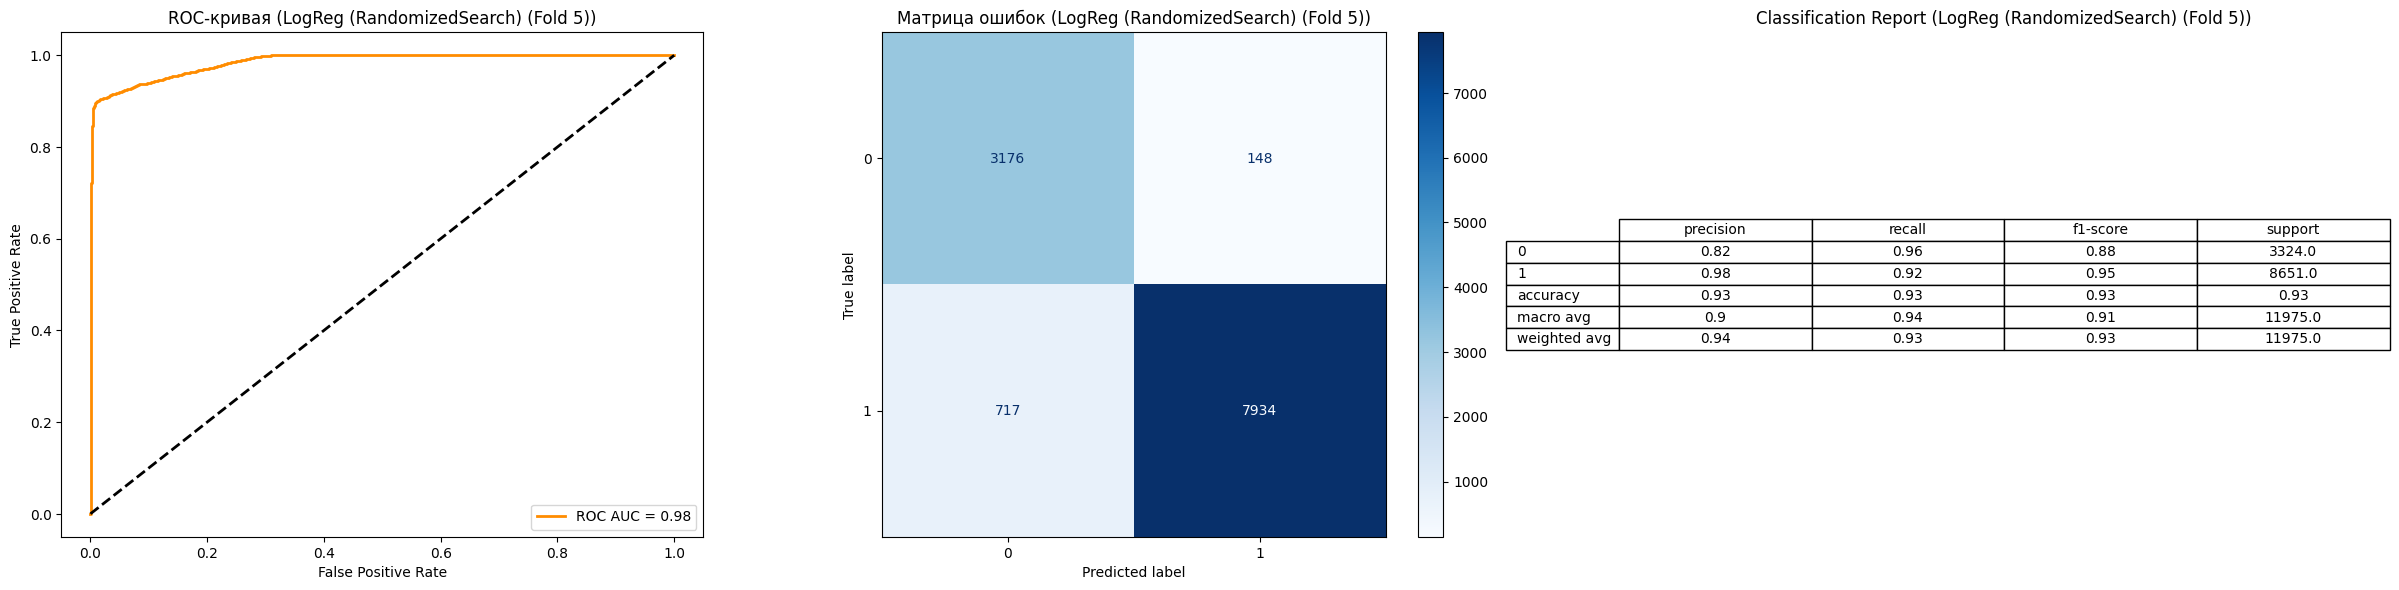

[I 2025-04-27 17:19:28,872] A new study created in memory with name: no-name-55126c6f-b1c3-45fa-9862-a0228518adec



Средние метрики для LogReg (RandomizedSearch):
Accuracy: 0.9266
Precision: 0.9813
Recall: 0.9159
F1: 0.9475
ROC AUC: 0.9848


[I 2025-04-27 17:19:29,409] Trial 0 finished with value: 0.8490641513758468 and parameters: {'C': 0.1767016940294795, 'penalty': 'l2'}. Best is trial 0 with value: 0.8490641513758468.
[I 2025-04-27 17:19:30,049] Trial 1 finished with value: 0.8387199676576075 and parameters: {'C': 506.1576888752306, 'penalty': 'l2'}. Best is trial 0 with value: 0.8490641513758468.
[I 2025-04-27 17:19:30,670] Trial 2 finished with value: 0.838622719740946 and parameters: {'C': 24.658329458549105, 'penalty': 'l2'}. Best is trial 0 with value: 0.8490641513758468.
[I 2025-04-27 17:19:31,265] Trial 3 finished with value: 0.8391658663091484 and parameters: {'C': 3.907967156822881, 'penalty': 'l2'}. Best is trial 0 with value: 0.8490641513758468.
[I 2025-04-27 17:19:31,660] Trial 4 finished with value: 0.8546729419789575 and parameters: {'C': 0.008632008168602538, 'penalty': 'l2'}. Best is trial 4 with value: 0.8546729419789575.
[I 2025-04-27 17:19:32,076] Trial 5 finished with value: 0.8546729419789575 and p

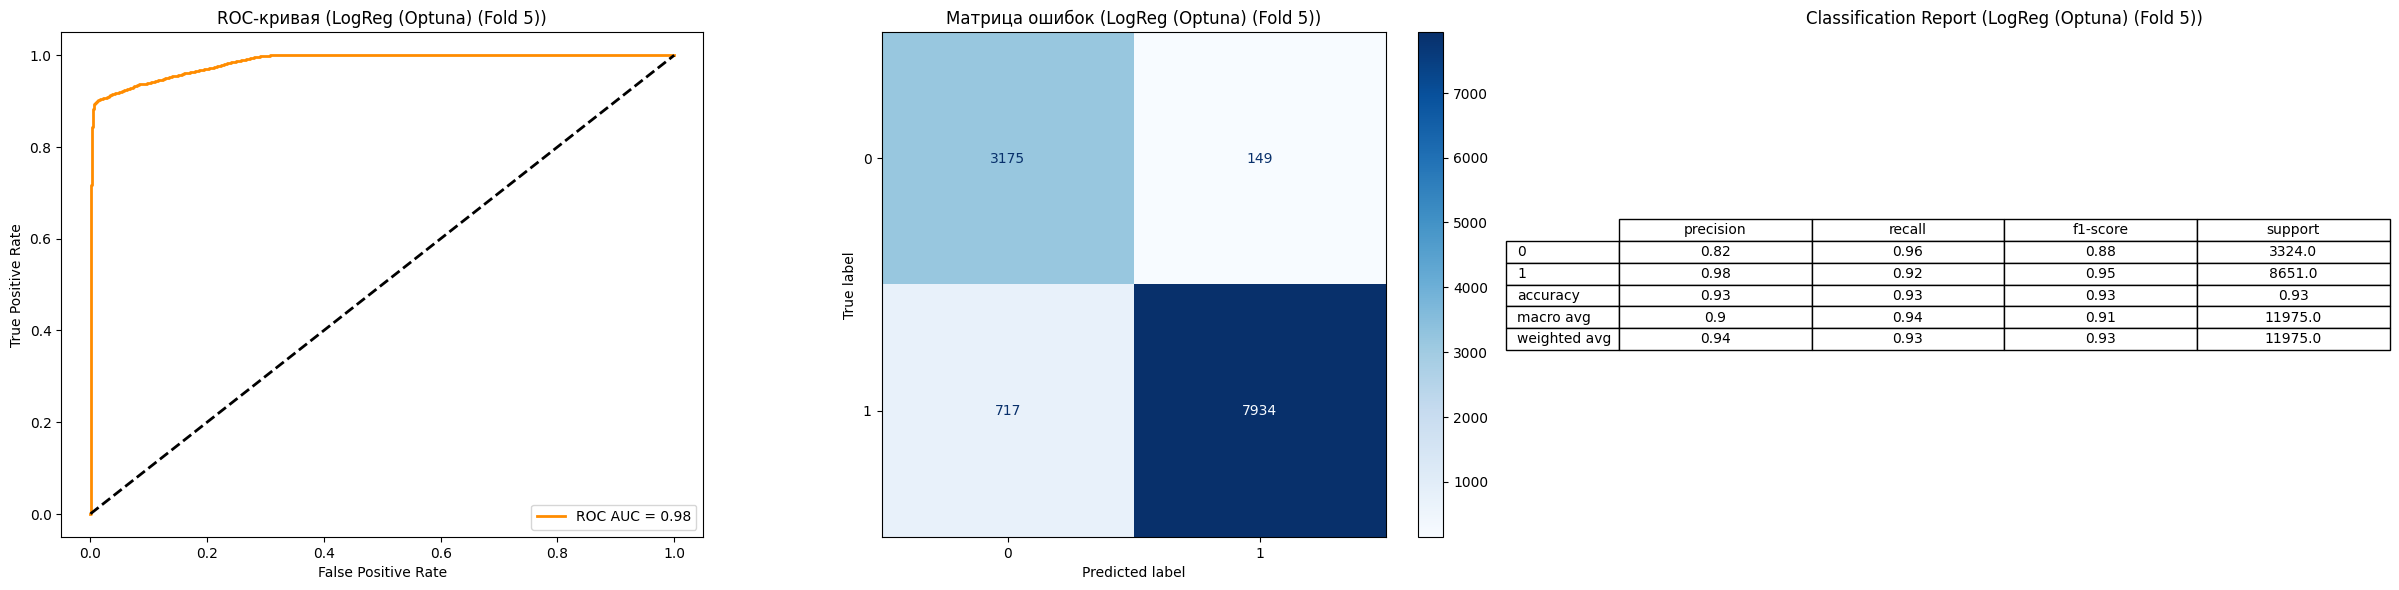


Средние метрики для LogReg (Optuna):
Accuracy: 0.9266
Precision: 0.9811
Recall: 0.9160
F1: 0.9474
ROC AUC: 0.9848


In [30]:
# Логистическая регрессия с GridSearchCV
logreg = GridSearchCV(
    LogisticRegression(solver='liblinear', max_iter=40),
    param_grid={
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10]
    },
    cv=3,
    scoring='f1'
)
evaluate_with_kfold(logreg, X, y, "LogReg (GridSearch)")

# Логистическая регрессия с RandomizedSearchCV
logreg_random = RandomizedSearchCV(
    LogisticRegression(solver='liblinear', max_iter=40),
    param_distributions={
        'C': loguniform(1e-2, 1e2),
        'penalty': ['l1', 'l2']
    },
    n_iter=10,
    cv=3,
    scoring='f1',
    random_state=42
)
evaluate_with_kfold(logreg_random, X, y, "LogReg (RandomizedSearch)")

# Логистическая регрессия с Optuna
def logreg_objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': 'liblinear'
    }
    model = LogisticRegression(**params, max_iter=40)
    pipeline = imbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    return np.mean(cross_val_score(pipeline, X, y, cv=3, scoring='f1'))

logreg_study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
logreg_study.optimize(logreg_objective, n_trials=10)
best_logreg = LogisticRegression(**logreg_study.best_params, max_iter=40)
evaluate_with_kfold(best_logreg, X, y, "LogReg (Optuna)")


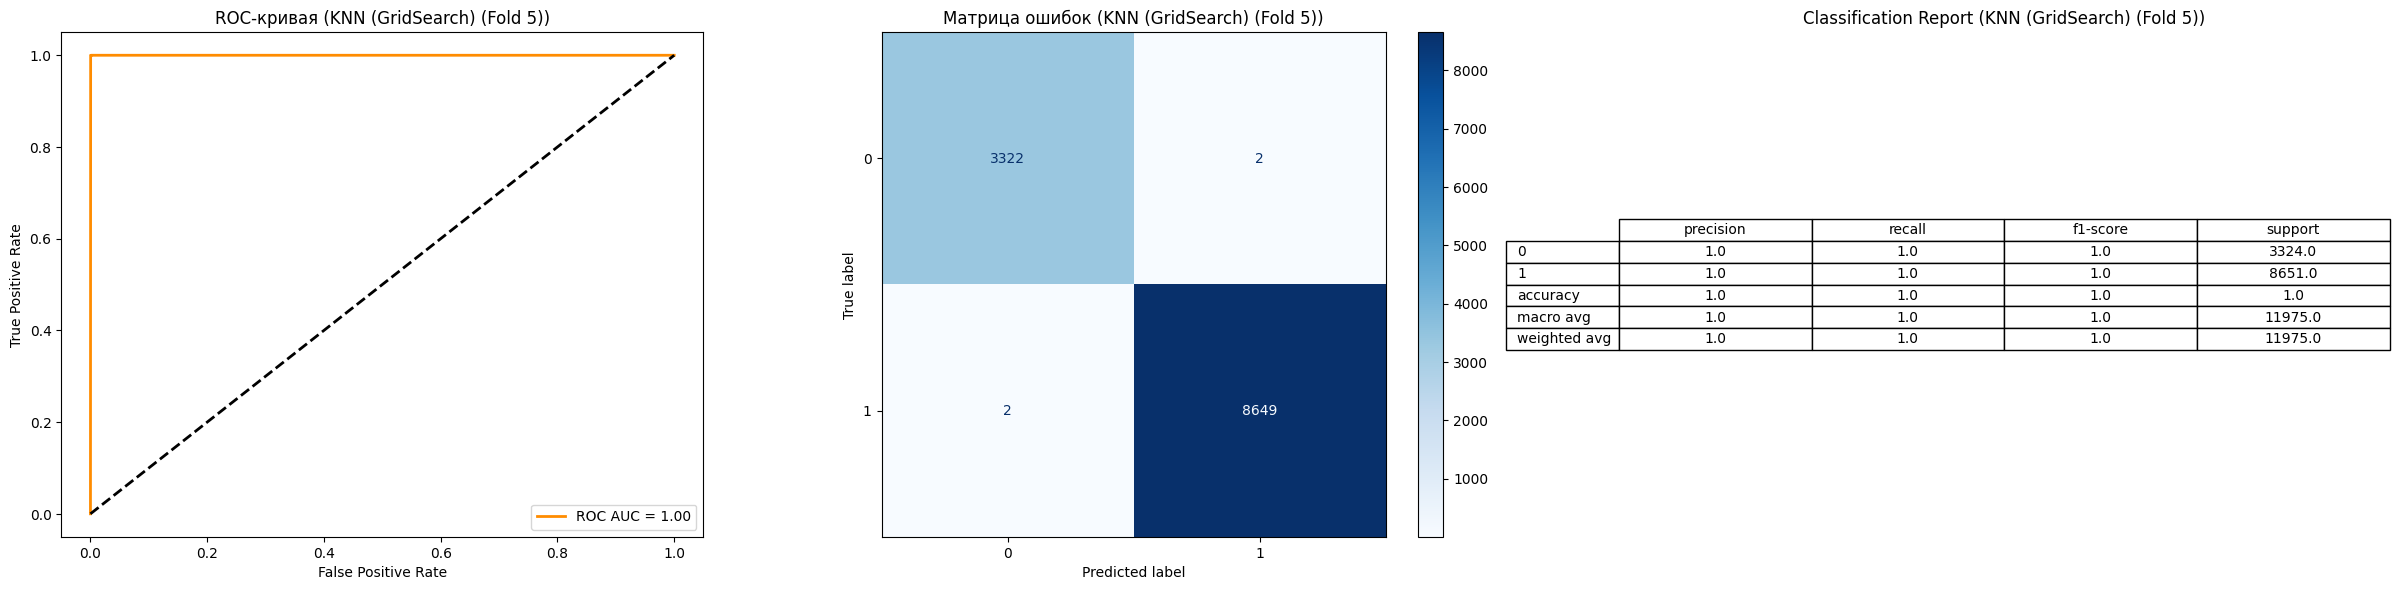


Средние метрики для KNN (GridSearch):
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1: 0.9998
ROC AUC: 0.9999


{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [31]:
# KNN с GridSearchCV
knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    cv=3,
    scoring='f1'
)
evaluate_with_kfold(knn, X, y, "KNN (GridSearch)")
knn.best_params_

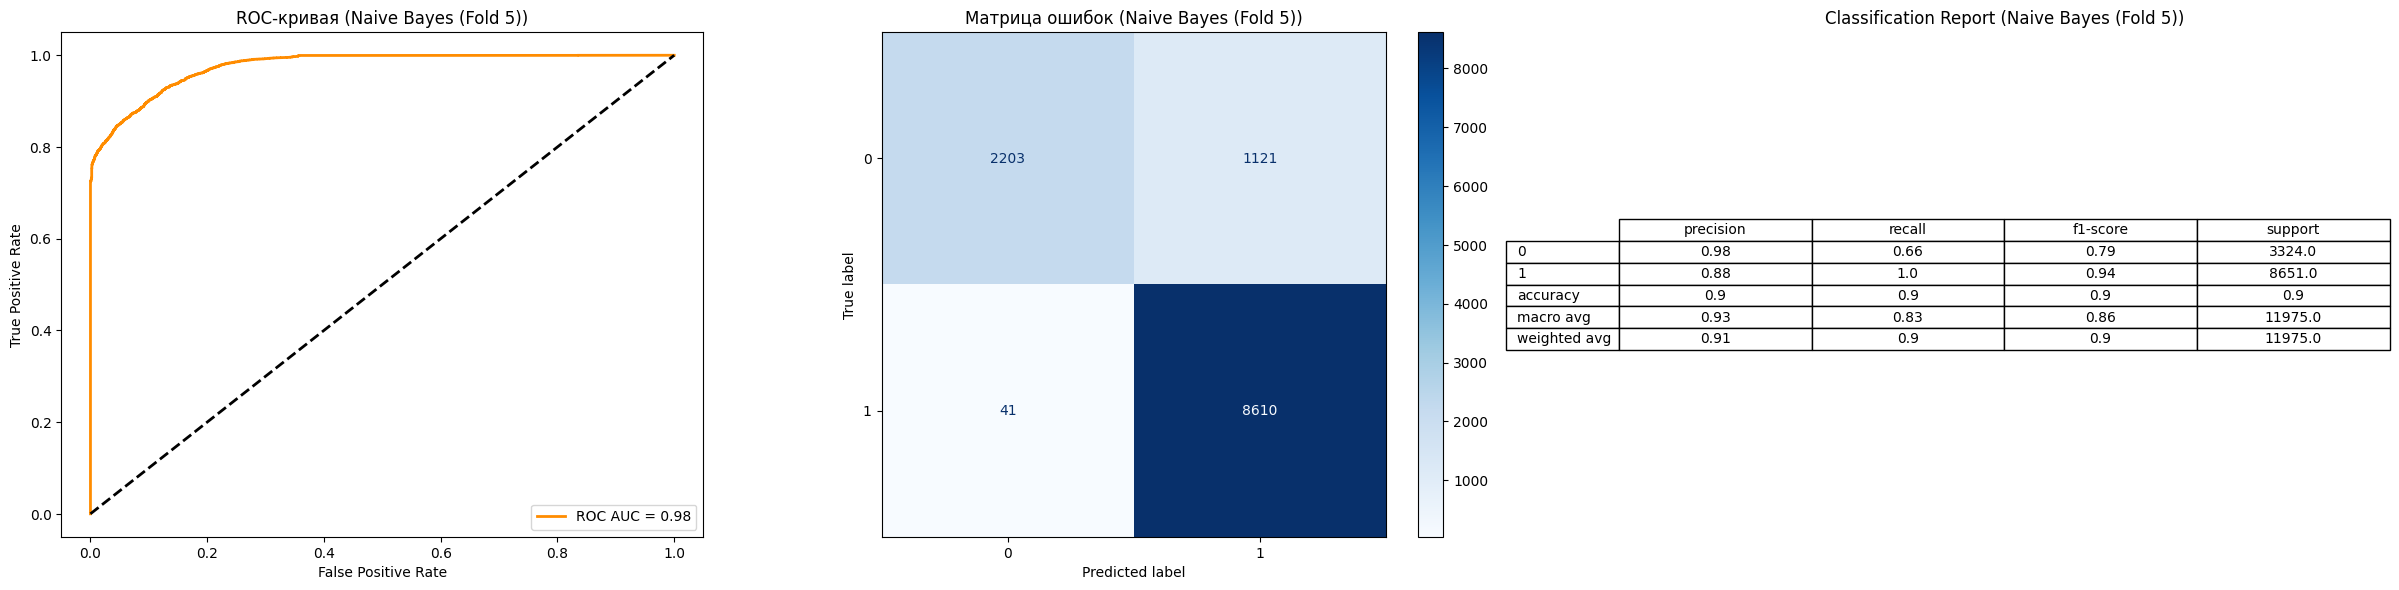


Средние метрики для Naive Bayes:
Accuracy: 0.9036
Precision: 0.8857
Recall: 0.9951
F1: 0.9372
ROC AUC: 0.9766


In [32]:
# Наивный Байес
evaluate_with_kfold(GaussianNB(), X, y, "Naive Bayes")

C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

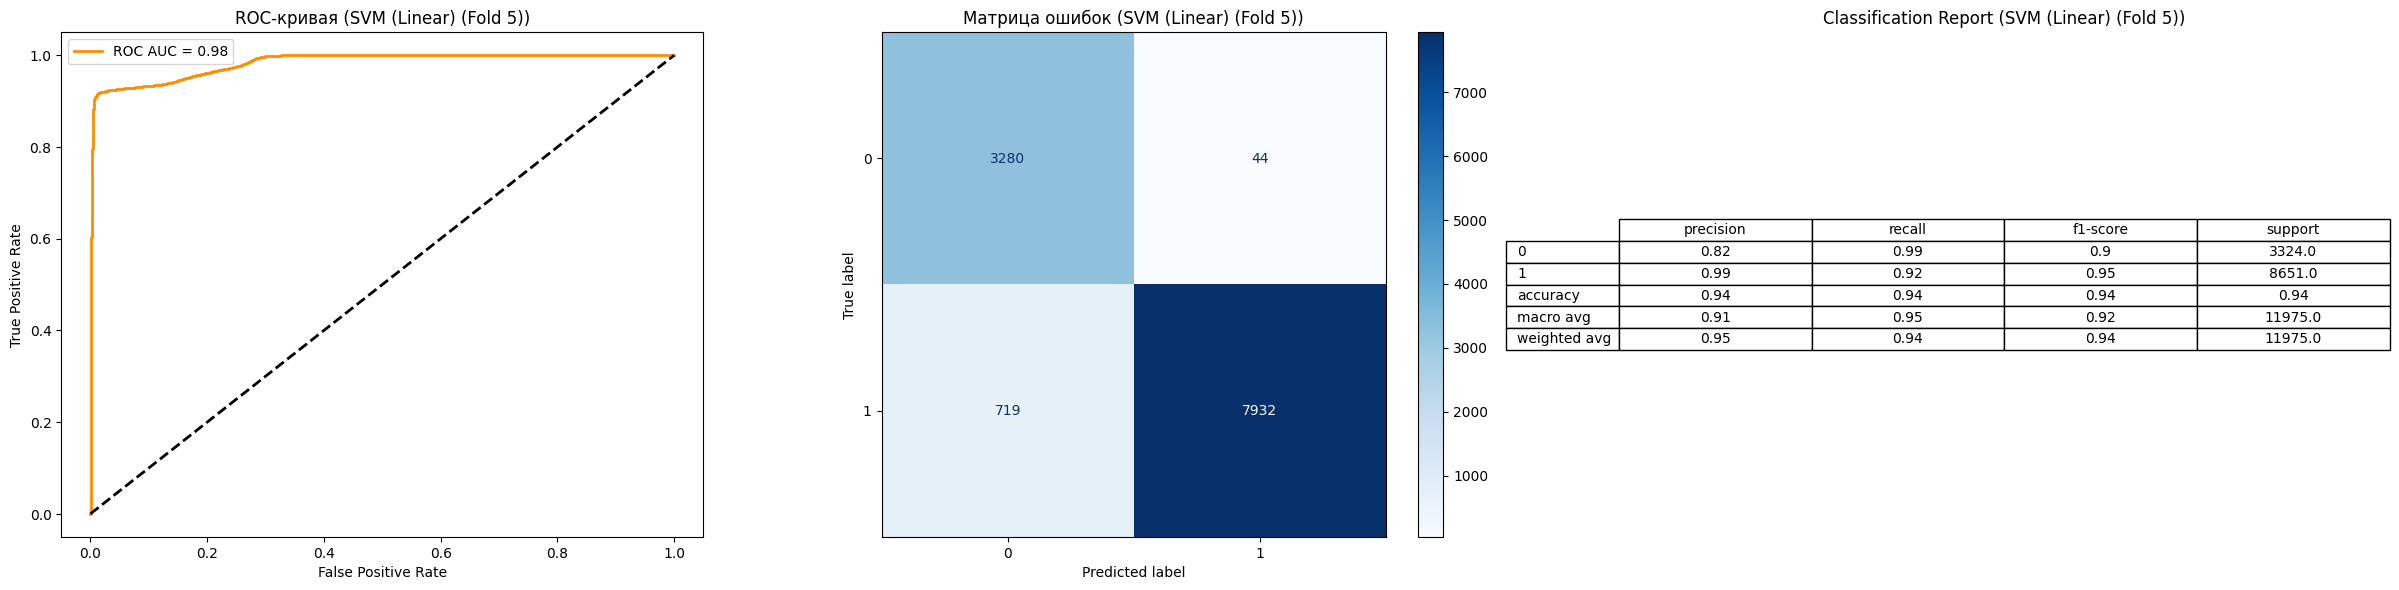


Средние метрики для SVM (Linear):
Accuracy: 0.9354
Precision: 0.9944
Recall: 0.9157
F1: 0.9534
ROC AUC: 0.9830


In [33]:
# SVM
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
evaluate_with_kfold(svm_linear, X, y, "SVM (Linear)")

C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

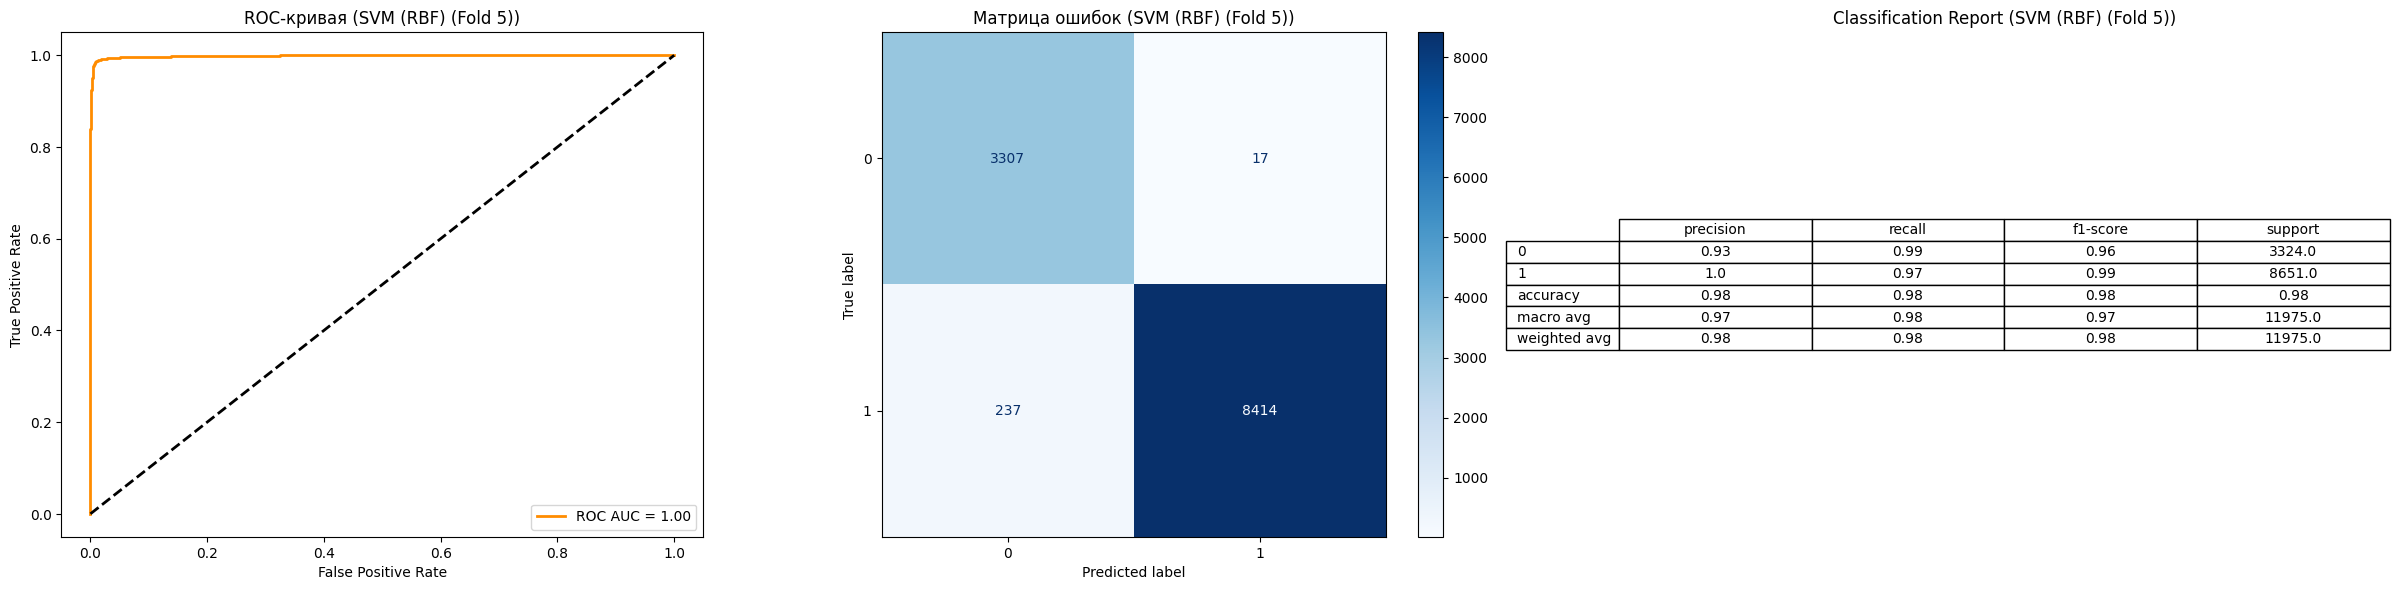


Средние метрики для SVM (RBF):
Accuracy: 0.9787
Precision: 0.9988
Recall: 0.9717
F1: 0.9851
ROC AUC: 0.9984


In [34]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
evaluate_with_kfold(svm_rbf, X, y, "SVM (RBF)")

C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedCla

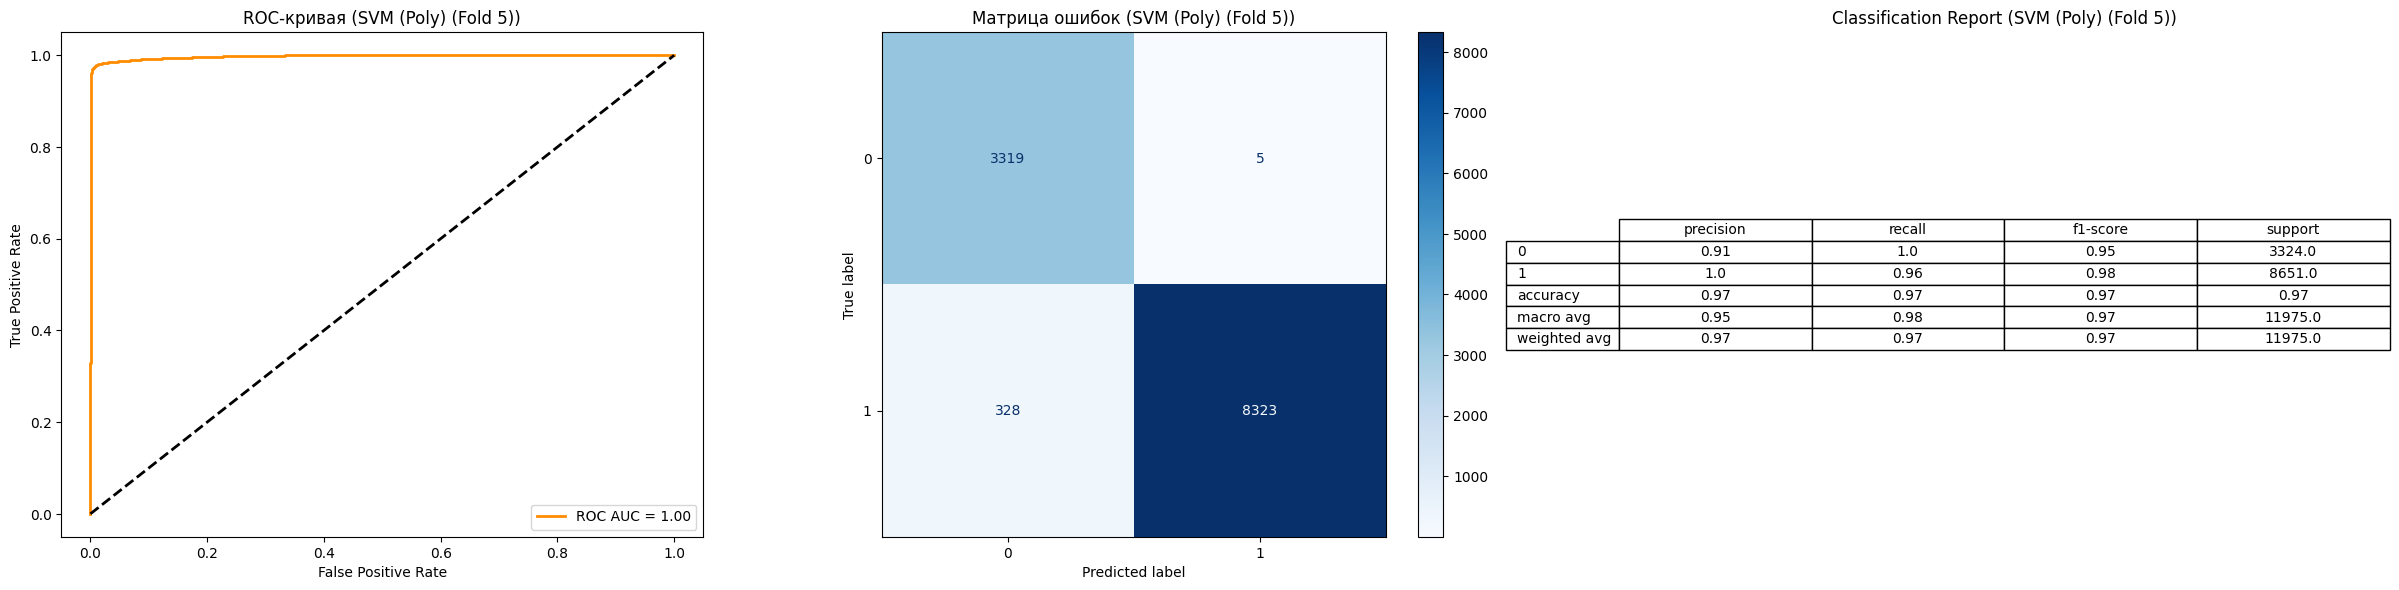


Средние метрики для SVM (Poly):
Accuracy: 0.9716
Precision: 0.9994
Recall: 0.9613
F1: 0.9800
ROC AUC: 0.9969


In [35]:
svm_poly = SVC(kernel='poly', probability=True, random_state=42)
evaluate_with_kfold(svm_poly, X, y, "SVM (Poly)")

# Вывод по лабораторной работе

Лучшей моделью признан алгоритм KNN!!!

### Исключительно высокие метрики качества:

- Accuracy 99.77% на тестовых данных свидетельствует о почти идеальной классификации.
- Precision, Recall и F1-score = 1.00 для обоих классов указывают на отсутствие значимых ошибок как в распознавании положительных (класс 1), так и отрицательных (класс 0) примеров.
- ROC-AUC = 0.9987 подтверждает высокую способность модели разделять классы.
- Немного ошибок (0+2)